In [1]:
import numpy as np
from qiskit.quantum_info import random_statevector

# 1 Qubit

In [2]:
n_qubits = 1

### Generate "unkown" state you want to learn

In [3]:
psi = random_statevector(2**n_qubits).data.reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [4]:
measurement_strings = ["0", "1", "+", "-", "i", "-i"]

zero = np.array([1, 0]).reshape(-1, 1)
one = np.array([0, 1]).reshape(-1, 1)
plus = 1/np.sqrt(2) * np.array([1, 1]).reshape(-1, 1)
minus = 1/np.sqrt(2) * np.array([1, -1]).reshape(-1, 1)
i = 1/np.sqrt(2) * np.array([1, 1j]).reshape(-1, 1)
minus_i = 1/np.sqrt(2) * np.array([1, -1j]).reshape(-1, 1)

basis_states = [zero, one, plus, minus, i, minus_i]

### Create measurement projectors

In [5]:
# 1 qubit
measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
measurement_op_dict = dict(zip(measurement_strings, measurement_operators))

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [6]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in measurement_operators]

probabilities = get_probabilities(unkown_dm)
prob_dict = dict(zip(measurement_strings, probabilities))

### Create tunable state
Parameterization from Kwiat group lecture: https://www.youtube.com/watch?v=-T_GiHE4VGg

In [7]:
def get_parameterized_dm(t1, t2, t3, t4):
    T = np.array([[t1,          0],
                  [t3 + 1j*t4, t2]])
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    return parameterized_rho

In [8]:
dm_parameters = np.random.uniform(low=-1, high=1, size=4)

In [9]:
parameterized_dm = get_parameterized_dm(*dm_parameters)

### Test that DM is valid

In [10]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [11]:
def get_probabilites_from_parameters(t1, t2, t3, t4):
    parameterized_dm = get_parameterized_dm(t1, t2, t3, t4)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [12]:
from scipy.special import kl_div

def kl_divergence(true_probs, t1, t2, t3, t4):
    probs = get_probabilites_from_parameters(t1, t2, t3, t4)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, *params)

In [13]:
from scipy.optimize import minimize

optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")

In [14]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(*found_params)

In [15]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

dm_fidelity(unkown_dm, found_dm)

0.9999267798498795

### Plot Density Matrices

In [16]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

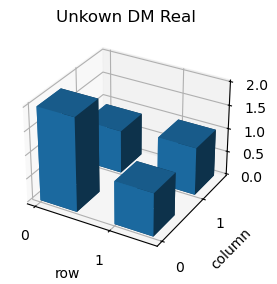

[[1.98912197 0.91424071]
 [0.91424071 1.01087803]]


In [18]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

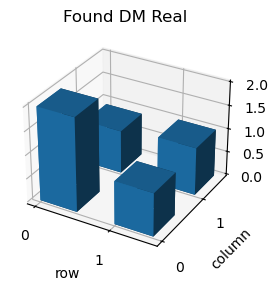

[[1.98908644 0.91430542]
 [0.91430542 1.01091356]]


In [19]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

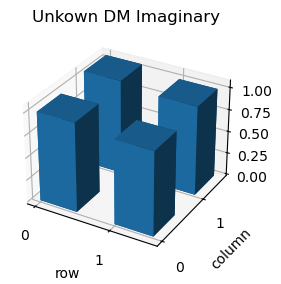

[[1.         0.94164723]
 [1.05835277 1.        ]]


In [20]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

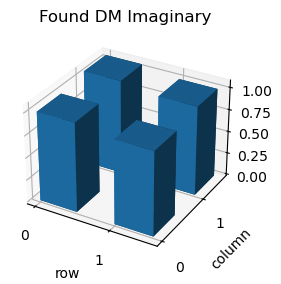

[[1.        0.9418817]
 [1.0581183 1.       ]]


In [21]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)